# Fashion MNIST VAE Experiments

In [1]:
import sys
import argparse

import matplotlib.pyplot as plt
import matplotlib.image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical
from torch.distributions.bernoulli import Bernoulli
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets.utils as dataset_utils
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import os
import gzip
import struct
import array
import numpy as np
from PIL import Image

from typing import Tuple

plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = 'gray'

In [2]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if (device.type == "cuda"):
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [3]:
torch.cuda.get_device_name()

'NVIDIA A100-SXM4-80GB'

In [4]:
def array_to_image(array):
    return torch.reshape(array, (1,28,28)).permute(1, 2, 0)

# concatenate the images for plotting
def concat_images(images, row, col, padding = 3):
    result = np.zeros((28*row+(row-1)*padding, 28*col+(col-1)*padding, 3))
    for i in range(row):
        for j in range(col):
            result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
    return result

## Creating Dataset

In [5]:
# Note: VAE models data distribution using Bernoulli
# all pixel values must in [0, 1]
# so don't add any transforms that screw that up
transform = transforms.Compose(
    [transforms.ToTensor()]
)

# noisy_transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.GaussianBlur(11, sigma=(1, 2))]
# )

trainset = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Visualize some of the data

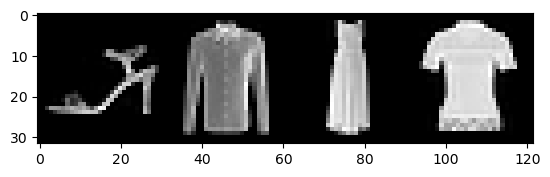

Sandal	Shirt	Dress	T-Shirt


In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random images
rand_idx = np.random.choice(len(trainset), 4)
images = [trainset[i][0] for i in rand_idx]
labels = [trainset[i][1] for i in rand_idx]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join(f'{labels_map[labels[j]]:5s}' for j in range(4)))

## VAE

In [7]:
eps = 1e-8

def visualize_data_space(vae):
    """
    Generate using the VAE
    """
    # sample 10 z from prior
    nsample = 10
    z_samples = torch.randn(nsample, vae.latent_dimension).to(device)

    # for each z, plot p(x|z)
    bernoulli_prob = vae.decoder(z_samples)
    dist_plots = np.array([array_to_image(dist).detach().cpu().numpy() for dist in bernoulli_prob])

    # sample x from p(x|z)
    x_samples = vae.sample_Bernoulli(bernoulli_prob)
    x_plots = np.array([array_to_image(img).detach().cpu().numpy() for img in x_samples])

    # put all the images together
    concat_img = concat_images(np.concatenate((dist_plots, x_plots), axis=0), 10, 2)

    plt.imshow(concat_img, cmap='gray', vmin=0, vmax=1)
    plt.savefig('data_space.png')


class Encoder(nn.Module):
    """
    Model for the encoder of the VAE. Models Q(z | x), distribution of latent variables given a data point
    Inputs:
        latent_dimension: the latent dimension of the encoder (# of latent variables)
        hidden_units: the number of hidden units
        data_dimension: dimensionality of input data
    """

    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc3_sigma = nn.Linear(hidden_units, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Args:
            x - input image [batch_size x data_dimension]

        Returns:
            parameters of a diagonal gaussian
            mean : [batch_size x latent_dimension]
            variance : [batch_size x latent_dimension]
        """

        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        mu = self.fc3_mu(x)
        log_sigma_square = self.fc3_sigma(x)
        sigma_square = torch.exp(log_sigma_square)
        return mu, sigma_square


class Decoder(nn.Module):
    """
    Model for the decoder of the VAE. Models P(x | z), distribution of data given a latent variable
    Inputs:
        latent_dimension: the latent dimension of the encoder (# of latent variables)
        hidden_units: the number of hidden units
        data_dimension: dimensionality of input data
    """
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dimension, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, data_dimension)
        # activations
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        """
        Args:
            z: latent codes sampled from the encoder [batch_size x latent_dimension]
        Returns:
            mean and variance of normal distribution for p(x | z)
        """
        z = self.tanh(self.fc1(z))
        z = self.tanh(self.fc2(z))
        p = self.sigmoid(self.fc3(z))
        return p


# VAE model
class VAE(nn.Module):
    """
    Variational autoencoder model. Combines the encoder with the decoder.
    """
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epochs = args.num_epochs
        self.e_path = args.e_path
        self.d_path = args.d_path

        # param of prior dist p(z)
        self.z_mu = torch.FloatTensor([0]*self.latent_dimension).repeat(self.batch_size, 1).to(device)
        self.z_sigma = torch.FloatTensor([2]*self.latent_dimension).repeat(self.batch_size, 1).to(device)

        self.mu_zero = torch.zeros(self.latent_dimension, device=device)
        self.sigma_I = torch.ones((1, self.latent_dimension), device=device)

        # Instantiate the encoder and decoder models
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters and continue training
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        """
        Sample from Diagonal Gaussian z ~ N(μ, σ^2 I)
        Args:
          mu: mean of the gaussian [batch_size x latent_dimension]
          sigma_square: variance of the gaussian [batch_size x latent_dimension]

        Returns:
          sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]
        """
        # sample using reparam trick (sampling from N(0, I) and translating/scaling)
        e = torch.randn(mu.shape).to(device)
        sample = mu + torch.sqrt(sigma_square)*e
        return sample

    @staticmethod
    def sample_Bernoulli(p):
        """
        Sampler from Bernoulli distribtion

        Args:
            p: the probability of pixels labeled 1 [batch_size x data_dimension]
        Returns:
            x: sample from bernoulli distribution with given p [batch_size x data_dimension], type should be torch.float32
        """
        m = Bernoulli(p)
        x = m.sample()
        return x

    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        """
        Compute Log-pdf of z under Diagonal Gaussian N(z|μ, σ^2 I)

        Args:
            z: sample [batch_size x latent_dimension]
            mu: mean of the gaussian distribution [batch_size x latent_dimension]
            sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]

        Returns:
            logprob: log-probability of a diagonal gaussian [batch_size]
        """
        m = MultivariateNormal(mu, torch.diag_embed(sigma_square).to(device))
        logprob = m.log_prob(z)
        return logprob

    # Compute log-pdf of x under Bernoulli
    @staticmethod
    def logpdf_bernoulli(x, p):
        """
        Args:
            x: samples [batch_size x data_dimension]
            p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        Returns:
            logprob: log-probability of a bernoulli distribution [batch_size]
        """
        # compute log probabilities for each sample separately
        logprob = torch.sum(x * torch.log(p + eps) + (1 - x) * torch.log(1 - p + eps), dim=1) # see cs446 hw3 p1.a
        return logprob

    def sample_z(self, mu, sigma_square):
        """
        Sample z ~ q(z|x)

        Args:
            mu: mean of the gaussian [batch_size x latent_dimension]
            sigma_square: variance of the gaussian [batch_size x latent_dimension]
        Returns:
            zs: samples from q(z|x) [batch_size x latent_dimension]
        """
        zs = self.sample_diagonal_gaussian(mu, sigma_square)
        # zs *= torch.normal(mean=torch.ones(zs.shape[0], 1), std=1.).to(device)
        return zs


    def elbo_loss(self, sampled_z, latent_mu, latent_sigma_square, x, p):
        """
        Variational Objective function we want to maximize

        Inputs
            sampled_z: samples z from the encoder [batch_size x latent_dimension]
            latent_mu: mean of q(z|x) [batch_size x latent_dimension]
            latent_sigma_square: variance of q(z|x) [batch_size x latent_dimension]
            x: data samples [batch_size x data_dimension]
            p: the probability of a pixel being labeled 1 (Bernoulli parameters) [batch_size x data_dimension]
        Output
            elbo: the ELBO loss (scalar)
        """

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q_z_x = self.logpdf_diagonal_gaussian(sampled_z, latent_mu, latent_sigma_square)

        # log_p_z(z) log probability of z under prior N(0, I)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, self.z_mu, self.z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p_x_z = self.logpdf_bernoulli(x, p)

        batch_res = log_p_x_z + log_p_z - log_q_z_x

        # monte carlo estimate of expected value (using one sample for efficiency)
        elbo = torch.mean(batch_res)
        return elbo


    def train(self, train_image_loader, lr):
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params, lr=lr)

        num_batches = int(np.ceil(len(train_image_loader) / self.batch_size))
        num_iters = self.num_epochs * num_batches

        i = 0
        for e in range(self.num_epochs):
            for batch_num, (x_minibatch, target) in enumerate(train_image_loader):
                x_minibatch = x_minibatch.to(device)
                # flatten image into a vector
                x_minibatch = torch.flatten(x_minibatch, start_dim=1)
                adam_optimizer.zero_grad()

                latent_mu, latent_sigma_square = self.encoder(x_minibatch)
                zs = self.sample_z(latent_mu, latent_sigma_square*self.sigma_I)
                p = self.decoder(zs)
                elbo = self.elbo_loss(zs, latent_mu, latent_sigma_square*self.sigma_I, x_minibatch, p)
                total_loss = -elbo
                total_loss.backward()
                adam_optimizer.step()

                if i%100 == 0:
                    print("Epoch: " + str(e) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))
                i += 1

        # Save Optimized Model Parameters
        # torch.save(self.encoder.state_dict(), self.e_path)
        # torch.save(self.decoder.state_dict(), self.d_path)

In [8]:
# the args for model
def parse_args():
    """
    Get args/params for VAE model
    """
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--e_path', type=str, default="d_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="e_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=512, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default=800, help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default=784*1, help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=888, help='Random seed')
    parser.add_argument('--num_epochs', type=int, default=100, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=256, help='Batch size.')

    args, unknown = parser.parse_known_args()
    return args

args = parse_args()

# set the random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

In [209]:
# make sure the number of data points is divisible by the batch size
# (otherwise causes problems since mean/std of latent distr is fixed for efficiency)
rand_idx = np.random.choice(len(trainset), (len(trainset)//args.batch_size)*args.batch_size)

trainloader = DataLoader([trainset[i] for i in rand_idx], batch_size=args.batch_size,
                            shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=args.batch_size,
                        shuffle=False, num_workers=0)

In [ ]:
vae = VAE(args).to(device)
vae.train(trainloader, lr=0.0001)

Epoch: 0, Iter: 0, ELBO:-624.7316284179688
Epoch: 0, Iter: 100, ELBO:-391.3973388671875
Epoch: 0, Iter: 200, ELBO:-365.518310546875
Epoch: 1, Iter: 300, ELBO:-333.53863525390625
Epoch: 1, Iter: 400, ELBO:-322.4190673828125
Epoch: 2, Iter: 500, ELBO:-306.22344970703125
Epoch: 2, Iter: 600, ELBO:-311.0057678222656
Epoch: 2, Iter: 700, ELBO:-301.11376953125
Epoch: 3, Iter: 800, ELBO:-313.746337890625
Epoch: 3, Iter: 900, ELBO:-305.1666259765625
Epoch: 4, Iter: 1000, ELBO:-306.65704345703125
Epoch: 4, Iter: 1100, ELBO:-300.24383544921875
Epoch: 5, Iter: 1200, ELBO:-300.70196533203125
Epoch: 5, Iter: 1300, ELBO:-298.289306640625
Epoch: 5, Iter: 1400, ELBO:-311.57574462890625
Epoch: 6, Iter: 1500, ELBO:-304.5685119628906
Epoch: 6, Iter: 1600, ELBO:-295.927490234375
Epoch: 7, Iter: 1700, ELBO:-299.2000732421875
Epoch: 7, Iter: 1800, ELBO:-296.91961669921875
Epoch: 8, Iter: 1900, ELBO:-292.441650390625
Epoch: 8, Iter: 2000, ELBO:-288.46380615234375
Epoch: 8, Iter: 2100, ELBO:-287.5206604003906

In [182]:
torch.save(vae, './fashion_mnist_vae_latent800.pkl')

In [9]:
vae2 = torch.load('fashion_mnist_vae_latent2.pkl')
vae20 = torch.load('fashion_mnist_vae_latent20.pkl')
vae200 = torch.load('fashion_mnist_vae_latent200.pkl')
vae800 = torch.load('fashion_mnist_vae_latent800.pkl')

### Visualizing Model Outputs

#### Latent Dim = 2

In [10]:
latentdim = 2

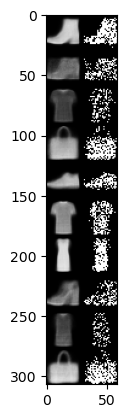

In [11]:
# visualize the latent space
visualize_data_space(vae2)

Checking how well the model is encoding/decoding training and testing images.

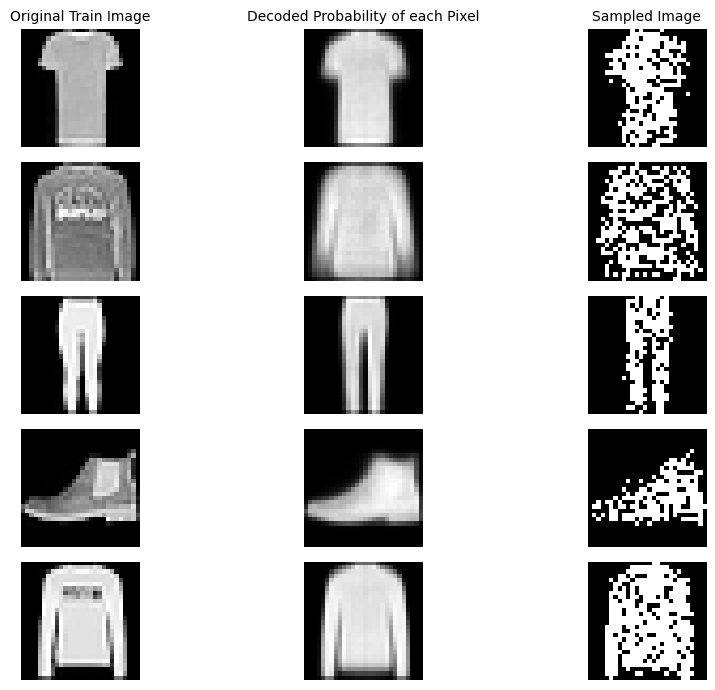

In [20]:
# train images

nimage = 5
rand_idx = np.random.choice(len(testset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 3, figsize=(10, 7))
ax[0][0].set_title('Original Train Image', fontsize=10)
ax[0][1].set_title('Decoded Probability of each Pixel', fontsize=10)
ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = trainset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae2.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae2.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i][1].imshow(array_to_image(p.cpu()))
    ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
plt.tight_layout()
plt.show()

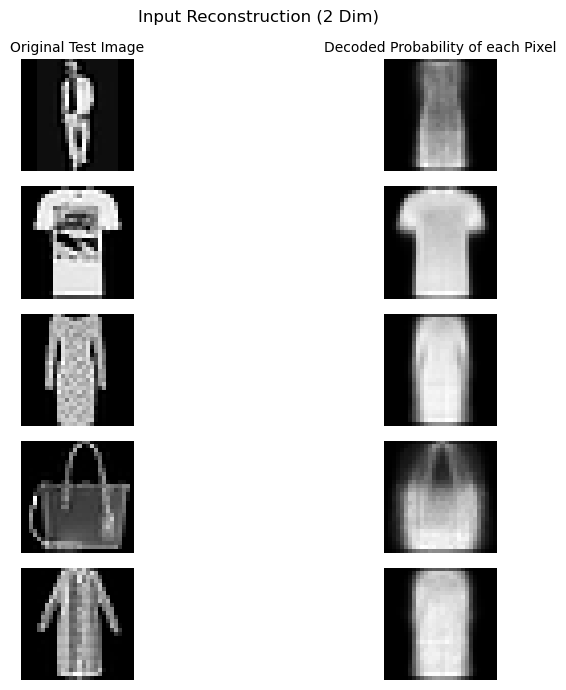

In [47]:
# test images

nimage = 5
rand_idx = np.random.choice(len(testset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 2, figsize=(10, 7))
ax[0][0].set_title('Original Test Image', fontsize=10)
ax[0][1].set_title('Decoded Probability of each Pixel', fontsize=10)
# ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = testset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae2.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae2.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i][1].imshow(array_to_image(p.cpu()))
    # ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    # ax[i][2].axis('off')
fig.suptitle('Input Reconstruction (2 Dim)')
plt.tight_layout()
plt.show()

Now we see how it generates new images

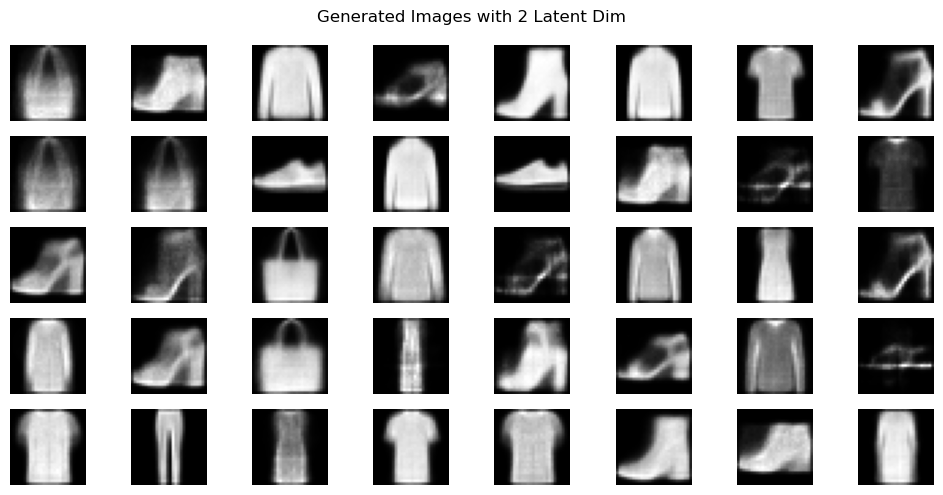

In [166]:
# generate new images (2 latent dim)
nimage = 40
z = torch.randn((nimage, latentdim), device=device)
gen = vae2.decoder(z).detach()

fig, ax = plt.subplots(5, 8, figsize=(10, 5))
for i in range(nimage):
    r = i//8
    c = i%8
    ax[r][c].imshow(array_to_image(gen[i].cpu()))
    ax[r][c].axis('off')
fig.suptitle('Generated Images with 2 Latent Dim')
plt.tight_layout()
plt.show()

It seems that the model with a latent dimension of 2 is able to best generate new images, where there is good variety in the images and they are well-defined (i.e., they don't look "blobby").

Visualizing the 2D Latent space just for fun because I think it's cool.

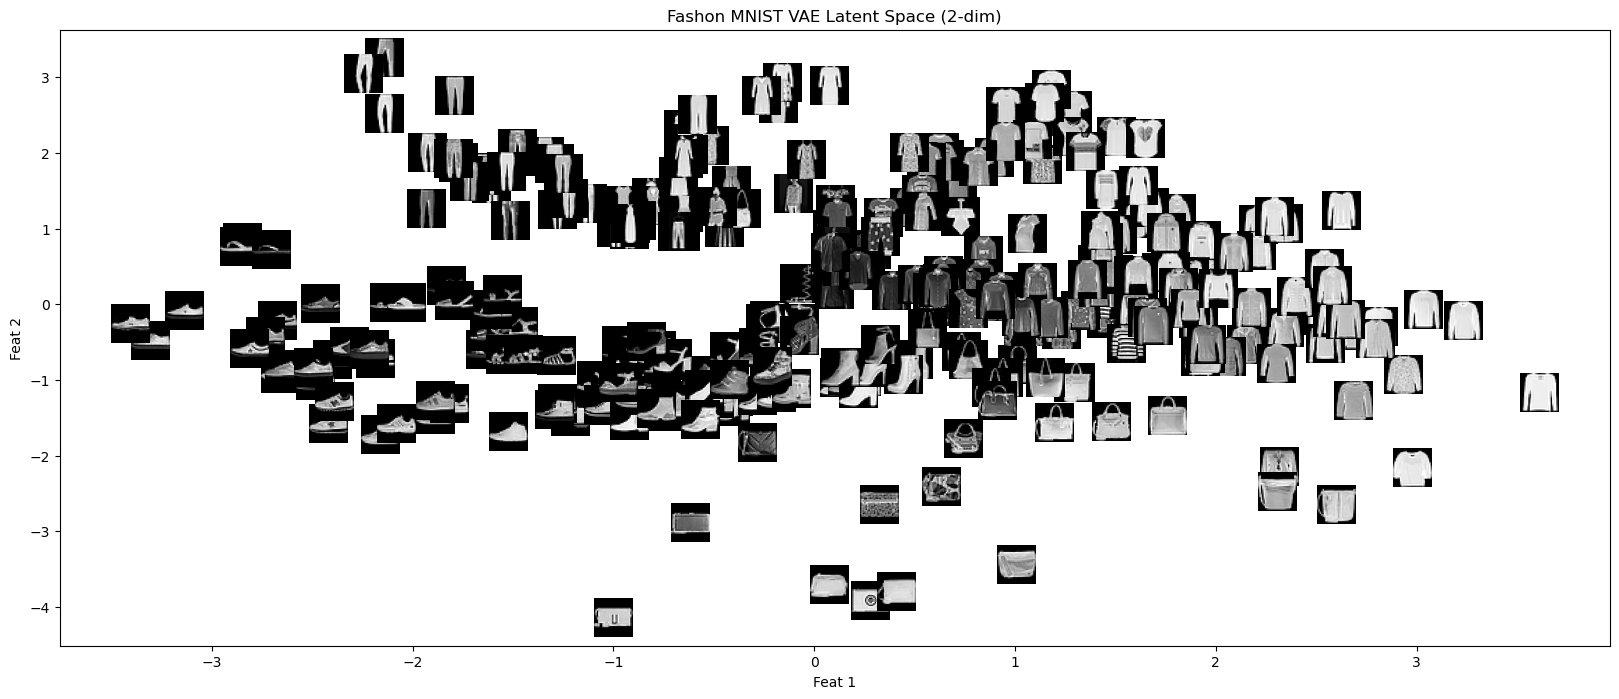

In [168]:
import matplotlib.offsetbox as offsetbox

N = 300 # number of images to plot
rand_idx = np.random.choice(len(testset), N)
rand_images = torch.stack([testset[i][0].flatten() for i in rand_idx], dim=0).to(device)
# get latent encoding of images
latent_mu, latent_s2 = vae2.encoder(rand_images)
latent_mu = latent_mu.detach()

# plot projected data but replacing dots with the image they represent
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(latent_mu[:,0].cpu(), latent_mu[:,1].cpu(), c='w')
ax.set_xlabel('Feat 1')
ax.set_ylabel('Feat 2')
ax.set_title('Fashon MNIST VAE Latent Space (2-dim)')

# adding images to the plot
for i in range(len(rand_idx)):
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(array_to_image(rand_images[i].cpu()), zoom=1),
        xy=(latent_mu[i, 0], latent_mu[i, 1]),
        frameon=False,
        pad=0.1,
    )
    ax.add_artist(imagebox)

plt.show()

#### Latent Dim = 20

In [186]:
latentdim = 20

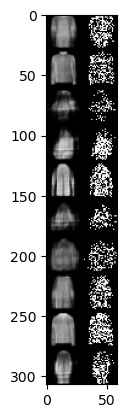

In [187]:
# visualize the latent space
visualize_data_space(vae20)

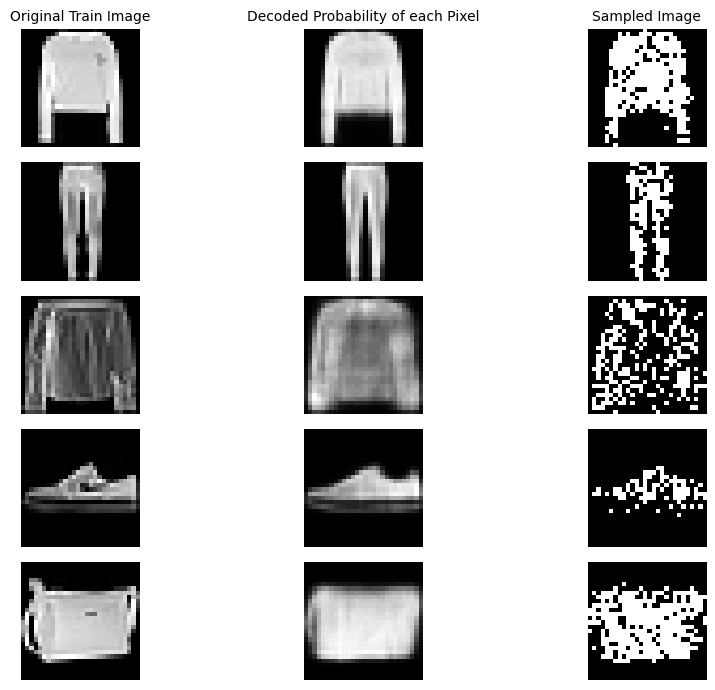

In [195]:
# train images

nimage = 5
rand_idx = np.random.choice(len(trainset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 3, figsize=(10, 7))
ax[0][0].set_title('Original Train Image', fontsize=10)
ax[0][1].set_title('Decoded Probability of each Pixel', fontsize=10)
ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = trainset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae20.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae20.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i][1].imshow(array_to_image(p.cpu()))
    ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
plt.tight_layout()
plt.show()

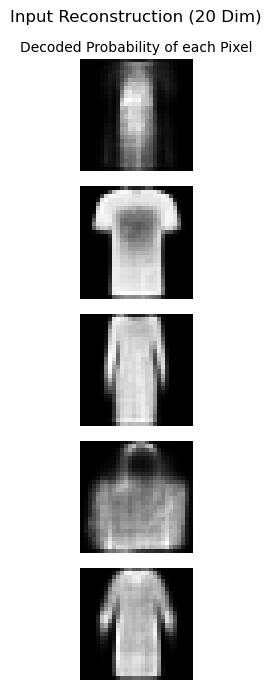

In [57]:
# test images

nimage = 5
# rand_idx = np.random.choice(len(testset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 1, figsize=(10, 7))
# ax[0][0].set_title('Original Test Image', fontsize=10)
ax[0].set_title('Decoded Probability of each Pixel', fontsize=10)
# ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = testset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae20.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae20.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    # ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i].imshow(array_to_image(p.cpu()))
    # ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i].axis('off')
    # ax[i][1].axis('off')
    # ax[i][2].axis('off')
fig.suptitle('Input Reconstruction (20 Dim)')
plt.tight_layout()
plt.show()

This model with a latent dimension of 20 seems to perform the best in encoding/decoding images. It is able to maintain the most detail from the original images. This is surprising, since one would expect the overparameterized latent space (i.e., dimension of 800 below) to be able to recover the original images almost exactly (but this is not the case).

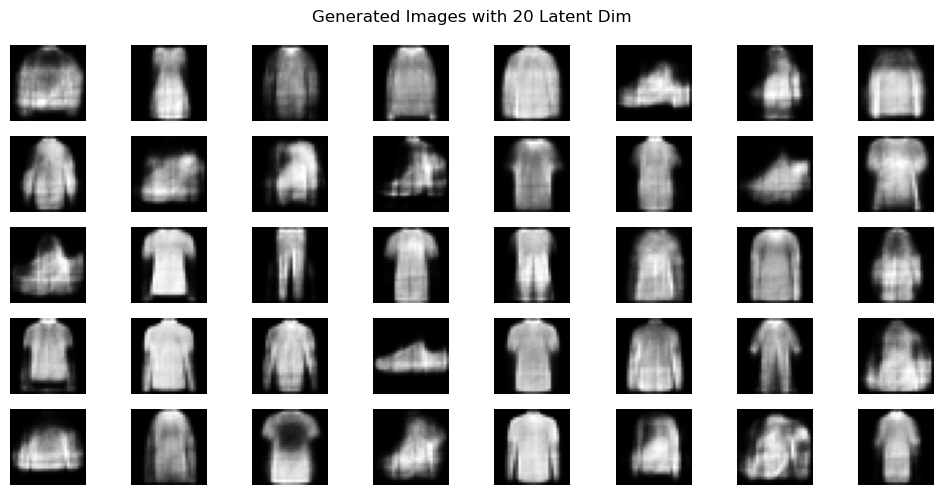

In [198]:
# generate new images (20 latent dim)
nimage = 40
z = torch.randn((nimage, latentdim), device=device)
gen = vae20.decoder(z).detach()

fig, ax = plt.subplots(5, 8, figsize=(10, 5))
for i in range(nimage):
    r = i//8
    c = i%8
    ax[r][c].imshow(array_to_image(gen[i].cpu()))
    ax[r][c].axis('off')
fig.suptitle('Generated Images with 20 Latent Dim')
plt.tight_layout()
plt.show()

Generated images here look a bit sloppier than those from the model with 2 latent dimensions.

#### Latent Dim = 200

In [24]:
latentdim = 200

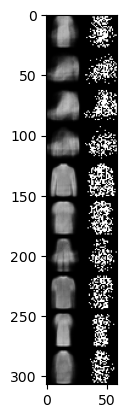

In [25]:
# visualize the latent space
visualize_data_space(vae200)

Encoding/Decoding Quality

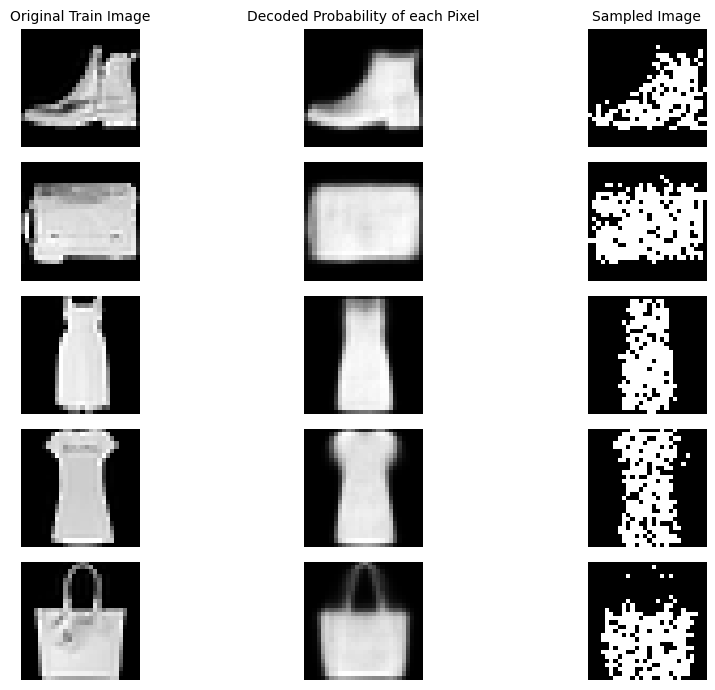

In [12]:
# train images

nimage = 5
rand_idx = np.random.choice(len(trainset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 3, figsize=(10, 7))
ax[0][0].set_title('Original Train Image', fontsize=10)
ax[0][1].set_title('Decoded Probability of each Pixel', fontsize=10)
ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = trainset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae200.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae200.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i][1].imshow(array_to_image(p.cpu()))
    ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
plt.tight_layout()
plt.show()

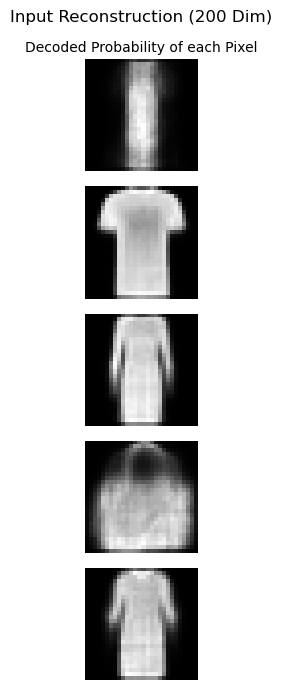

In [55]:
# test images

nimage = 5
# rand_idx = np.random.choice(len(testset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 1, figsize=(10, 7))
# ax[0][0].set_title('Original Test Image', fontsize=10)
ax[0].set_title('Decoded Probability of each Pixel', fontsize=10)
# ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = testset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae200.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae200.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    # ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i].imshow(array_to_image(p.cpu()))
    # ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i].axis('off')
    # ax[i][1].axis('off')
    # ax[i][2].axis('off')
fig.suptitle('Input Reconstruction (200 Dim)')
plt.tight_layout()
plt.show()

Now we generate images

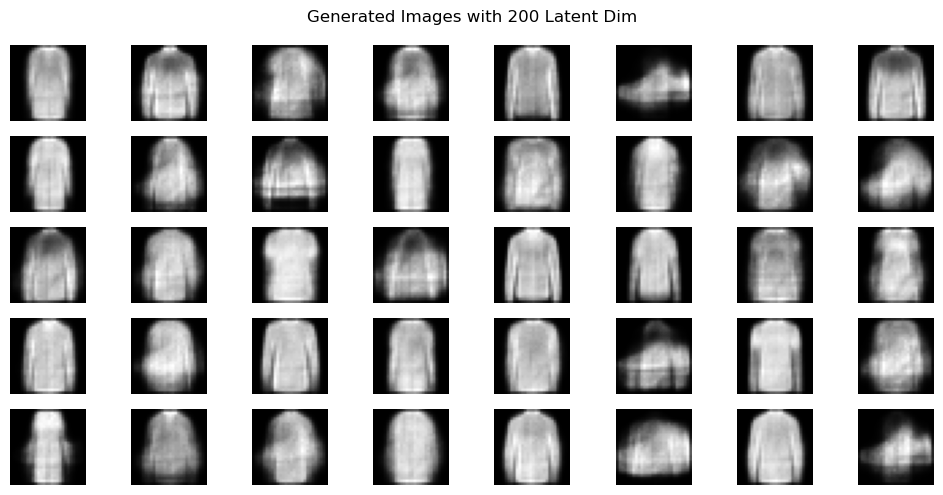

In [26]:
# generate new images (200 latent dim)
nimage = 40
z = torch.randn((nimage, latentdim), device=device)
gen = vae200.decoder(z).detach()

fig, ax = plt.subplots(5, 8, figsize=(10, 5))
for i in range(nimage):
    r = i//8
    c = i%8
    ax[r][c].imshow(array_to_image(gen[i].cpu()))
    ax[r][c].axis('off')
fig.suptitle('Generated Images with 200 Latent Dim')
plt.tight_layout()
plt.show()

With this higher dimensional latent space, almost all of the generated images are the same. This may be due to the latent sequences being typical as the dimension of the latent space gets larger, concentrating in an area corresponding to an output with a single set of features.

#### Latent Dim = 800

Overparameterized model (latent space has higher dimension than the original data)

In [27]:
latentdim = 800

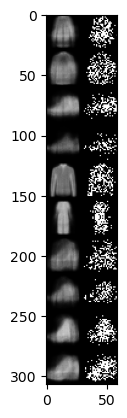

In [10]:
# visualize the latent space
visualize_data_space(vae800)

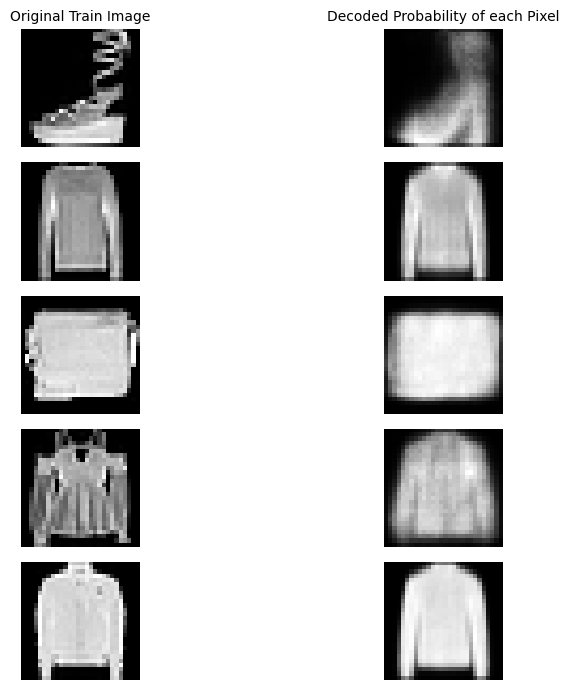

In [35]:
# train images

nimage = 5
rand_idx = np.random.choice(len(trainset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 3, figsize=(10, 7))
ax[0][0].set_title('Original Train Image', fontsize=10)
ax[0][1].set_title('Decoded Probability of each Pixel', fontsize=10)
ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = trainset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae800.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae800.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i][1].imshow(array_to_image(p.cpu()))
    ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')
plt.tight_layout()
plt.show()

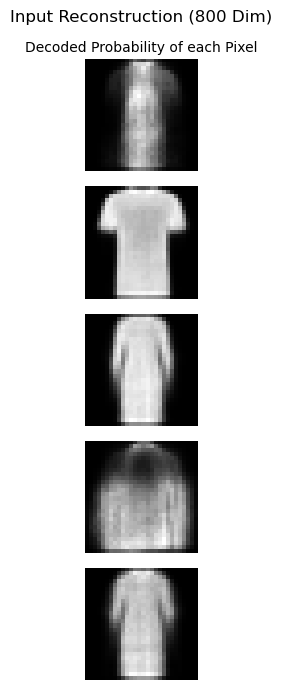

In [54]:
# test images

nimage = 5
# rand_idx = np.random.choice(len(testset), nimage)

# set up plots
fig, ax = plt.subplots(nimage, 1, figsize=(10, 7))
# ax[0][0].set_title('Original Test Image', fontsize=10)
ax[0].set_title('Decoded Probability of each Pixel', fontsize=10)
# ax[0][2].set_title('Sampled Image', fontsize=10)

for i, idx in enumerate(rand_idx):
    image = testset[idx][0].to(device)
    
    # get latent
    mu, sigma_square = vae800.encoder(image.flatten())
    mu = mu.detach()
    sigma_square = sigma_square.detach()
    # use latent to reconstruct a digit
    p = vae800.decoder(mu).detach()
    # sample a digit
    sample = VAE.sample_Bernoulli(p).detach()
    
    # plot
    # ax[i][0].imshow(array_to_image(image.cpu()))
    ax[i].imshow(array_to_image(p.cpu()))
    # ax[i][2].imshow(array_to_image(sample.cpu())) 
    ax[i].axis('off')
    # ax[i][1].axis('off')
    # ax[i][2].axis('off')
fig.suptitle('Input Reconstruction (800 Dim)')
plt.tight_layout()
plt.show()

The model kinda sucks as encoding/decoding images. You would expect it to just be able to remember the input image exactly in the latent space and reproduce it, but that's not the case. Could this be a limitation of training? I argue that it's not by typicality of sequences sampled from latent space (remember that the latent space is drawn from $\mathcal{N}(\mu_{\phi}, \sigma_{\phi}^2 I)$, so all elements in the sampled vector are independent and drawn from $\mathcal{N}(\mu_i, \sigma^2)$ )

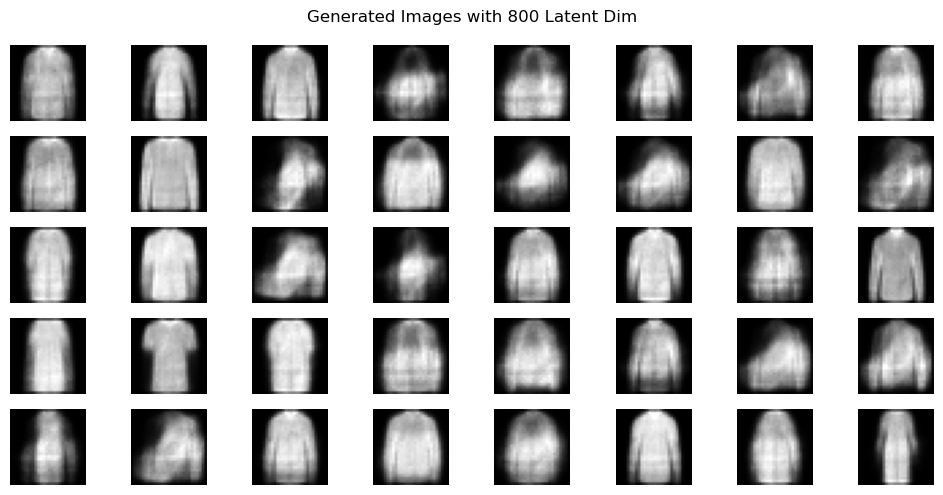

In [29]:
# generate new images (800 latent dim)
nimage = 40
z = torch.randn((nimage, latentdim), device=device)
gen = vae800.decoder(z).detach()

fig, ax = plt.subplots(5, 8, figsize=(10, 5))
for i in range(nimage):
    r = i//8
    c = i%8
    ax[r][c].imshow(array_to_image(gen[i].cpu()))
    ax[r][c].axis('off')
fig.suptitle('Generated Images with 800 Latent Dim')
plt.tight_layout()
plt.show()

## Studying Prior Collapse

### Latent Dim = 2

  0%|          | 0/1000 [00:00<?, ?it/s]

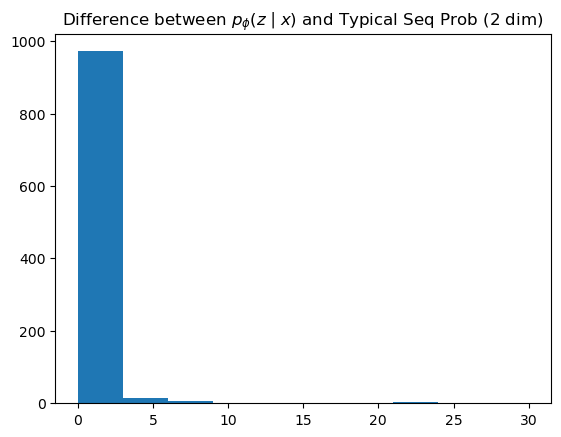

In [15]:
# with 2 latent dim
latent_dim = 2
mu_zero = torch.zeros(latent_dim, device=device)
sigma_I = torch.ones((1, latent_dim), device=device)

# pick some random images, encode them, sample encoding distribution and then see their probability under the prior
N = 1000
rand_idx = np.random.choice(len(trainset), N)
latent_logprobs = []
typical_diff = []
for i in tqdm(rand_idx):
    qz_mu, qz_s2 = vae2.encoder(trainset[i][0].flatten().to(device))
    qz_mu = qz_mu.reshape(1, -1)
    z = vae2.sample_z(qz_mu, qz_s2)
    pz = VAE.logpdf_diagonal_gaussian(z, mu_zero, sigma_I)
    latent_logprobs.append(pz.item())

    # compute difference btwn this prob and prob of typical sequence under this latent distr
    ent = 0.5 * torch.log(qz_s2 * 2 * np.pi * np.e)
    typical_prob = -latent_dim * ent
    pz_post = VAE.logpdf_diagonal_gaussian(z, qz_mu, qz_s2*sigma_I)
    diff = torch.abs(pz_post - typical_prob)
    diff_norm = diff / torch.abs(pz_post)
    typical_diff.append(diff_norm.item())
latent_logprobs = torch.tensor(latent_logprobs)
typical_diff = torch.tensor(typical_diff)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].hist(latent_logprobs)
# ax[0].set_title('Log Prob of Sampled Latents from Training (2 Dim) Under Prior $\mathcal{N}(0, I)$')
plt.hist(typical_diff, range=[0, 30])
plt.title('Difference between $p_{\phi}(z \mid x)$ and Typical Seq Prob (2 dim)')
plt.show()

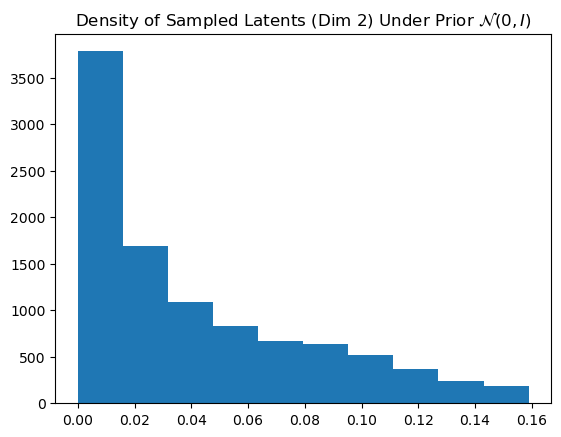

In [65]:
# actual densities (not log prob)
plt.hist(np.exp(latent_logprobs))
plt.title('Density of Sampled Latents (Dim 2) Under Prior $\mathcal{N}(0, I)$')
plt.show()

In [66]:
print(f'Avg Logprog: {torch.mean(latent_logprobs)}\n')
print(f'Avg Diff from Typical Prob (normalized): {typical_diff.mean()}\n')

# range of logprobs (expect this to get smaller as latent dim increases by typicality argument)
latent_dim = 2
avg_logprob_iqr= (torch.quantile(latent_logprobs, 0.75) - torch.quantile(latent_logprobs, 0.25)) / latent_dim
avg_logprob_range = (max(latent_logprobs) - min(latent_logprobs)) / latent_dim
print(f'Estimated Log Probability IQR: {avg_logprob_iqr}')
print(f'Estimated Log Probability Range: {avg_logprob_range}')
print(f'Variance of Log Probs: {torch.var(latent_logprobs)}')

Avg Logprog: -4.013728618621826

Avg Diff from Typical Prob (normalized): 1.93540620803833

Estimated Log Probability IQR: 1.0869388580322266
Estimated Log Probability Range: 5.669996738433838
Variance of Log Probs: 2.869633436203003


Probabilities **much further from being typical** than in the higher dimension latent spaces.

### Latent Dim = 20

  0%|          | 0/1000 [00:00<?, ?it/s]

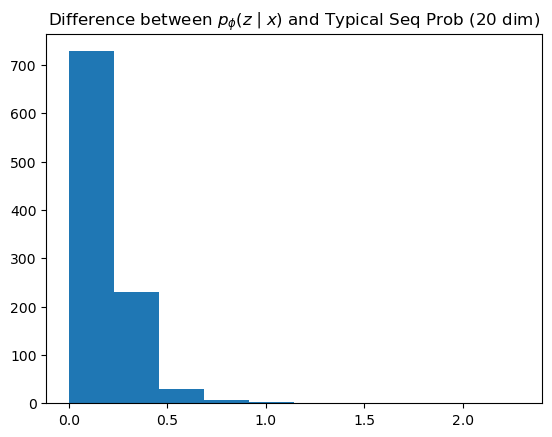

In [16]:
# with 20 latent dim
latent_dim = 20
mu_zero = torch.zeros(latent_dim, device=device)
sigma_I = torch.ones((1, latent_dim), device=device)

# pick some random images, encode them, sample encoding distribution and then see their probability under the prior
N = 1000
rand_idx = np.random.choice(len(trainset), N)
latent_logprobs = []
typical_diff = []
for i in tqdm(rand_idx):
    qz_mu, qz_s2 = vae20.encoder(trainset[i][0].flatten().to(device))
    qz_mu = qz_mu.reshape(1, -1)
    z = vae20.sample_z(qz_mu, qz_s2)
    pz = VAE.logpdf_diagonal_gaussian(z, mu_zero, sigma_I)
    latent_logprobs.append(pz.item())

    # compute difference btwn this prob and prob of typical sequence under this latent distr
    ent = 0.5 * torch.log(qz_s2 * 2 * np.pi * np.e)
    typical_prob = -latent_dim * ent
    pz_post = VAE.logpdf_diagonal_gaussian(z, qz_mu, qz_s2*sigma_I)
    diff = torch.abs(pz_post - typical_prob)
    diff_norm = diff / torch.abs(pz_post)
    typical_diff.append(diff_norm.item())
latent_logprobs = torch.tensor(latent_logprobs)
typical_diff = torch.tensor(typical_diff)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].hist(latent_logprobs)
# ax[0].set_title('Log Prob of Sampled Latents from Training (20 Dim) Under Prior $\mathcal{N}(0, I)$')
plt.hist(typical_diff)
plt.title('Difference between $p_{\phi}(z \mid x)$ and Typical Seq Prob (20 dim)')
plt.show()

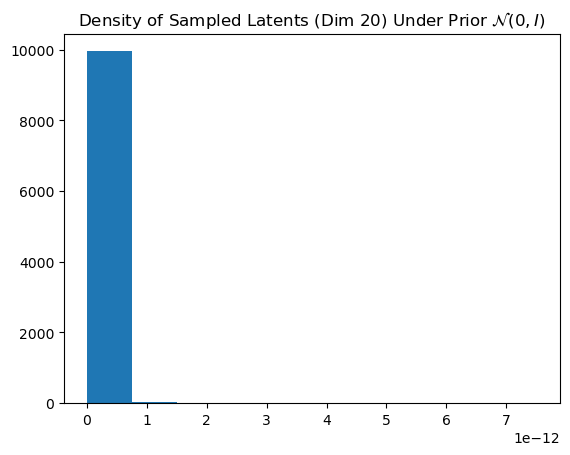

In [68]:
# actual densities (not log prob)
plt.hist(np.exp(latent_logprobs))
plt.title('Density of Sampled Latents (Dim 20) Under Prior $\mathcal{N}(0, I)$')
plt.show()

In [69]:
print(f'Avg Logprog: {torch.mean(latent_logprobs)}\n')
print(f'Avg Diff from Typical Prob (normalized): {typical_diff.mean()}\n')

# range of logprobs (expect this to get smaller as latent dim increases by typicality argument)
latent_dim = 20
avg_logprob_iqr= (torch.quantile(latent_logprobs, 0.75) - torch.quantile(latent_logprobs, 0.25)) / latent_dim
avg_logprob_range = (max(latent_logprobs) - min(latent_logprobs)) / latent_dim
print(f'Estimated Log Probability IQR: {avg_logprob_iqr}')
print(f'Estimated Log Probability Range: {avg_logprob_range}')
print(f'Variance of Log Probs: {torch.var(latent_logprobs)}')

Avg Logprog: -38.62836837768555

Avg Diff from Typical Prob (normalized): 0.1657201498746872

Estimated Log Probability IQR: 0.3499404788017273
Estimated Log Probability Range: 2.469381809234619
Variance of Log Probs: 26.496875762939453


### Latent Dim = 200

  0%|          | 0/1000 [00:00<?, ?it/s]

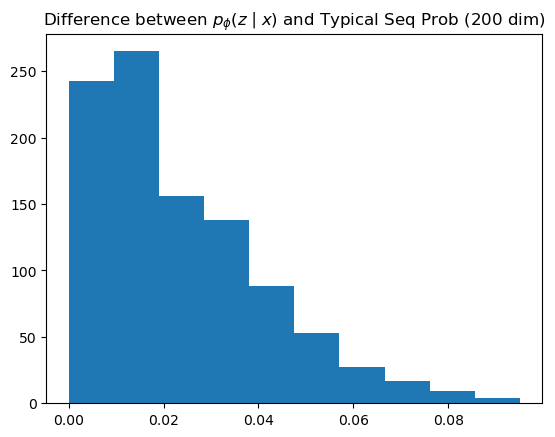

In [17]:
# with 200 latent dim
latent_dim = 200
mu_zero = torch.zeros(latent_dim, device=device)
sigma_I = torch.ones((1, latent_dim), device=device)

# pick some random images, encode them, sample encoding distribution and then see their probability under the prior
N = 1000
rand_idx = np.random.choice(len(trainset), N)
latent_logprobs = []
typical_diff = []
for i in tqdm(rand_idx):
    qz_mu, qz_s2 = vae200.encoder(trainset[i][0].flatten().to(device))
    qz_mu = qz_mu.reshape(1, -1)
    z = vae200.sample_z(qz_mu, qz_s2)
    pz = VAE.logpdf_diagonal_gaussian(z, mu_zero, sigma_I)
    latent_logprobs.append(pz.item())

    # compute difference btwn this prob and prob of typical sequence under this latent distr
    ent = 0.5 * torch.log(qz_s2 * 2 * np.pi * np.e)
    typical_prob = -latent_dim * ent
    pz_post = VAE.logpdf_diagonal_gaussian(z, qz_mu, qz_s2*sigma_I)
    diff = torch.abs(pz_post - typical_prob)
    diff_norm = diff / torch.abs(pz_post)
    typical_diff.append(diff_norm.item())
latent_logprobs = torch.tensor(latent_logprobs)
typical_diff = torch.tensor(typical_diff)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].hist(latent_logprobs)
# ax[0].set_title('Log Prob of Sampled Latents from Training (200 Dim) Under Prior $\mathcal{N}(0, I)$')
plt.hist(typical_diff)
plt.title('Difference between $p_{\phi}(z \mid x)$ and Typical Seq Prob (200 dim)')
plt.show()

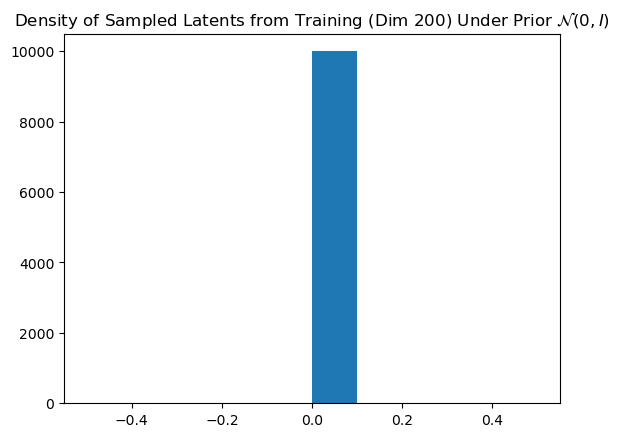

In [71]:
# actual densities (not log prob)
plt.hist(torch.exp(latent_logprobs))
plt.title('Density of Sampled Latents from Training (Dim 200) Under Prior $\mathcal{N}(0, I)$')
plt.show()

In [72]:
print(f'Avg Logprog: {torch.mean(latent_logprobs)}\n')
print(f'Avg Diff from Typical Prob (normalized): {typical_diff.mean()}\n')

# range of logprobs (expect this to get smaller as latent dim increases by typicality argument)
latent_dim = 200
avg_logprob_iqr= (torch.quantile(latent_logprobs, 0.75) - torch.quantile(latent_logprobs, 0.25)) / latent_dim
avg_logprob_range = (max(latent_logprobs) - min(latent_logprobs)) / latent_dim
print(f'Estimated Log Probability IQR: {avg_logprob_iqr}')
print(f'Estimated Log Probability Range: {avg_logprob_range}')
print(f'Variance of Log Probs: {torch.var(latent_logprobs)}')

Avg Logprog: -384.9951477050781

Avg Diff from Typical Prob (normalized): 0.024181172251701355

Estimated Log Probability IQR: 0.1427365094423294
Estimated Log Probability Range: 0.797507643699646
Variance of Log Probs: 447.5140380859375


Seems like the probability of sequences drawn from the posterior of the latent space are approaching those of the typical set under the posterior (despite the components not being i.i.d.)

### Latent Dim = 800

  0%|          | 0/1000 [00:00<?, ?it/s]

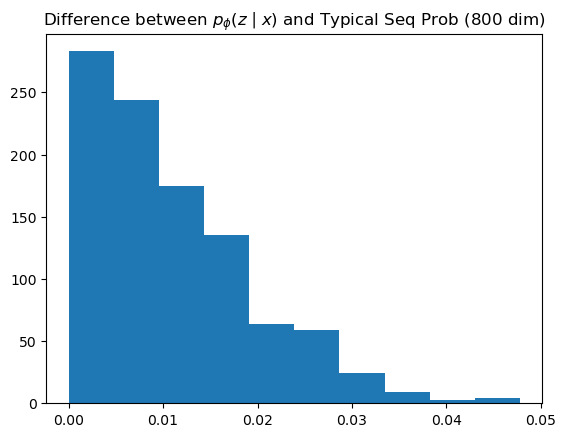

In [19]:
# with 200 latent dim
latent_dim = 800
mu_zero = torch.zeros(latent_dim, device=device)
sigma_I = torch.ones((1, latent_dim), device=device)

# pick some random images, encode them, sample encoding distribution and then see their probability under the prior
N = 1000
rand_idx = np.random.choice(len(trainset), N)
latent_logprobs = []
typical_diff = []
for i in tqdm(rand_idx):
    qz_mu, qz_s2 = vae800.encoder(trainset[i][0].flatten().to(device))
    qz_mu = qz_mu.reshape(1, -1)
    z = vae800.sample_z(qz_mu, qz_s2)
    pz = VAE.logpdf_diagonal_gaussian(z, mu_zero, sigma_I)
    latent_logprobs.append(pz.item())

    # compute difference btwn this prob and prob of typical sequence under this latent distr
    ent = 0.5 * torch.log(qz_s2 * 2 * np.pi * np.e)
    typical_prob = -latent_dim * ent
    pz_post = VAE.logpdf_diagonal_gaussian(z, qz_mu, qz_s2*sigma_I)
    diff = torch.abs(pz_post - typical_prob)
    diff_norm = diff / torch.abs(pz_post)
    typical_diff.append(diff_norm.item())
latent_logprobs = torch.tensor(latent_logprobs)
typical_diff = torch.tensor(typical_diff)

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].hist(latent_logprobs)
# ax[0].set_title('Log Prob of Sampled Latents from Training (200 Dim) Under Prior $\mathcal{N}(0, I)$')
plt.hist(typical_diff)
plt.title('Difference between $p_{\phi}(z \mid x)$ and Typical Seq Prob (800 dim)')
plt.show()

### Some Numerical Experiments

To see how different distributions and noise behave. Ignore...

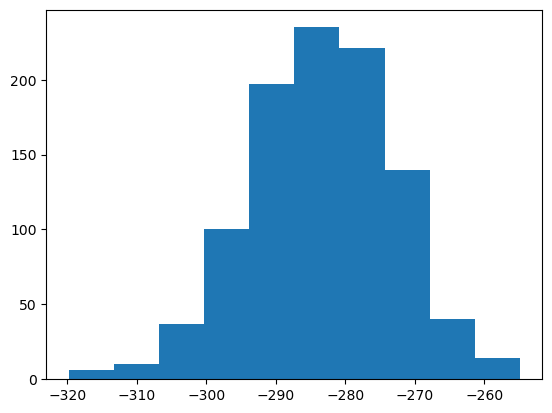

In [245]:
s = torch.randn((1000, 200), device=device)
# s *= torch.normal(mean=torch.ones((1000, 1)), std=1.).to(device)
# s = torch.concat([VAE.sample_diagonal_gaussian(torch.zeros(200, device=device), torch.ones((1, 200), device=device) + torch.abs(torch.randn((1, 200), device=device))) for _ in range(1000)], dim=0)
# s = 0.5*torch.sqrt(torch.abs(s)) * torch.sign(s)
probs = VAE.logpdf_diagonal_gaussian(s, torch.zeros(s.shape[1], device=device), torch.ones((1, s.shape[1]), device=device))

plt.hist(probs.cpu())
plt.show()

In [246]:
torch.var(probs)

tensor(107.3450, device='cuda:0')

0it [00:00, ?it/s]

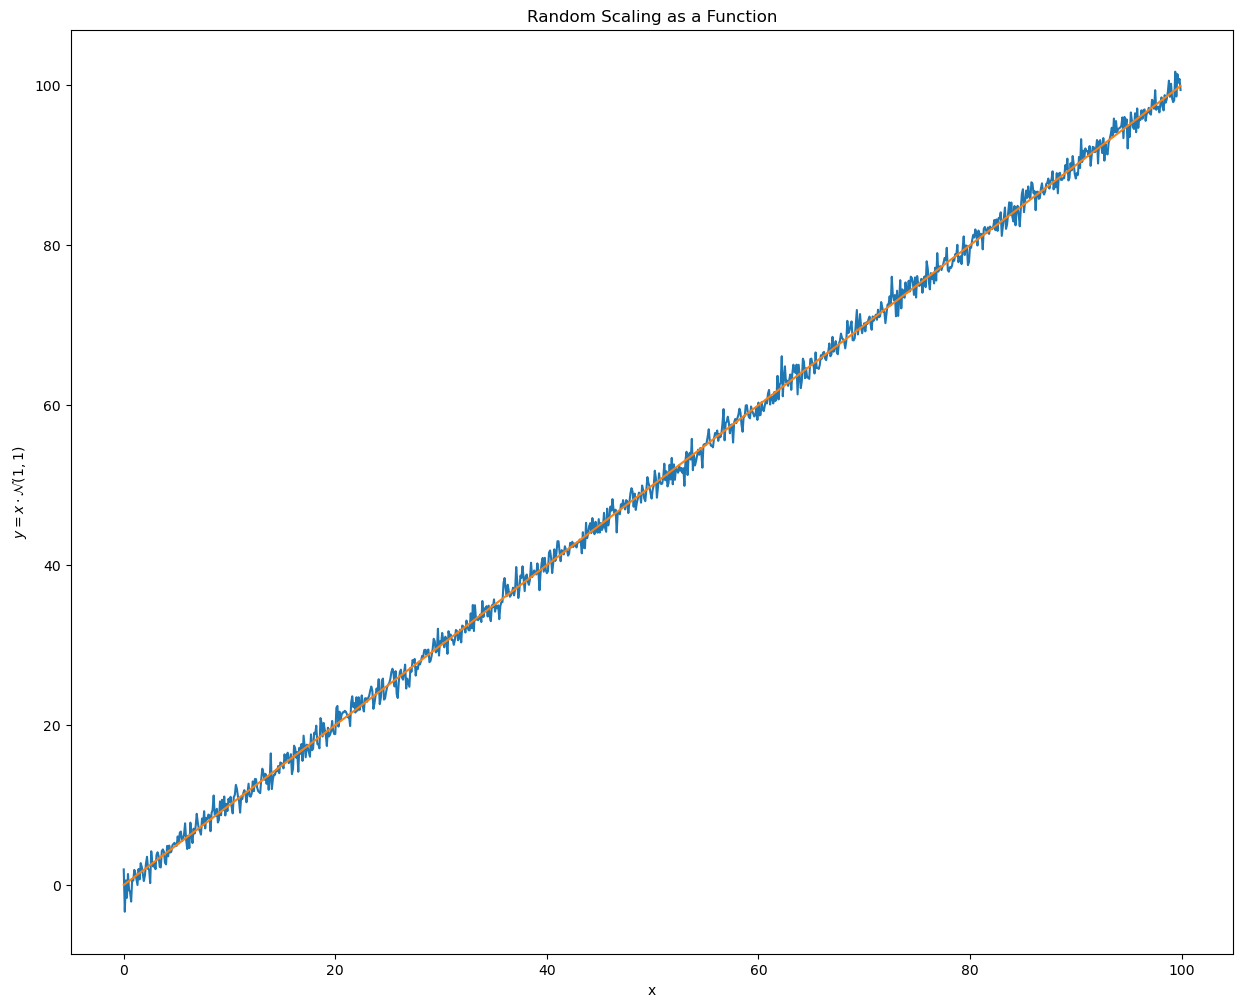

In [99]:
xs = torch.arange(0, 100, 0.1)
ys = torch.empty(xs.shape)
for i, x in tqdm(enumerate(xs)):
    ys[i] = x + VAE.sample_diagonal_gaussian(torch.tensor(0), torch.tensor(1))

plt.figure(figsize=(15, 12))
plt.plot(xs.cpu(), ys.cpu())
plt.plot(xs.cpu(), xs.cpu())
plt.title('Random Scaling as a Function')
plt.xlabel('x')
plt.ylabel('$y = x \cdot \mathcal{N}(1, 1)$')
plt.show()